# HMC on Endometrial Cancer data

logistic regression for endometrical cancer _(Endometriumkarzinom)_ [1]. 

 - example taken from [2] to compare Metropolis-Hastings with HMC and NUTS
 - MH used $10E6$ steps to fit within $2.58$min
 - quantiles obtained by [2]:
 ```
        2.5%    25%    50%    75%   97.5%
b0  -0.345  1.268  2.721  4.683  9.335
PI  -1.413 -0.766 -0.455 -0.158  0.366
EH  -3.402 -2.515 -2.100 -1.722 -1.082
NV   2.107  5.229  8.126 12.041 21.319
 ```



## Model Definition

 - logistic regression with $p = Pr(y=1 \vert X) = \frac{1}{1 + \exp{−X\beta}}$
 - $f(y \vert X,\beta)= \prod p^{y_i} (1−p)^{1−y_i}$
 - $\beta \sim \mathcal{N}(0,\sigma^2_{\beta}I)$
 - parameter vector $\theta = (\beta_0, \dots, \beta_3)'$
 - derive prop. log posterior and its gradient
     $$
     \begin{align}
         \log p(\beta \vert \cdot) &\propto \log p(y \vert \cdot) + \log p(\beta \vert \cdot)  \\
         \nabla_{\beta} \log p(\beta \vert \cdot) &\propto \nabla_{\beta} \log p(\beta \vert \cdot) 
     \end{align}
     $$

In [1]:
import datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import pickle
import time
import warnings
import sys
sys.path.append("..")
warnings.filterwarnings('ignore')

# hmc implementation 
from hmc_sampling import run_hmc_sampler
# log posterior and grad. of log posterior 
from endometrial_functions import log_posterior, log_posterior_grad
from utils_sampling import gelman_rubin, quantiles_per_chain
from utilities_plotting import plot_histograms, plot_traces

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv("../data/endometrial/endometrial.dat", 
                   sep=r"\s+", header=0)
data.shape

(79, 4)

In [3]:
# standardize the fatures PI and EH
X = data[["PI", "EH", "NV"]].to_numpy()
X[:,0] = (X[:, 0] - X[:,0].mean()) / X[:,0].std()
X[:,1] = (X[:, 1] - X[:,1].mean()) / X[:,1].std()
X[:,2] = X[:,2] - .5

# add intercept
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
# print(f"inspect head of data:\n {X[:10, :]}")

# separate the labels 
y = data["HG"].to_numpy()
# print(f"inspect head of labels:\n {y[:10]}")

### HMC Setup 

In [4]:
# generate random init. params based on prioris 
coeffs1 = np.ones(4)
coeffs2 = np.random.rand(4)
coeffs3 = np.random.randn(4)
coeffs4 = np.random.randn(4) * 10
coeffs = np.array([coeffs1, coeffs2, coeffs3, coeffs4])
print(f"init coeff: \n{coeffs}")

# covariance matrix for kinetic energy
mass_matrix = np.eye(4) * 10

init coeff: 
[[ 1.          1.          1.          1.        ]
 [ 0.61433905  0.79237203  0.55307887  0.33063199]
 [-0.45150289  1.75242333 -0.79222025  1.56342312]
 [-5.33310497  0.97044151 -5.75547734 17.95327088]]


In [7]:
# set hyperparameters 
sampling_steps = int(1E4)
stepsize = 0.1
leapfrog_steps = 10
burnin = 2500

In [8]:
# track runtime 
start = time.time()

# run HMC sampling 
samples, acceptance_probs = run_hmc_sampler(init_params=coeffs, 
                                            total_iterations=sampling_steps, burnin=burnin, 
                                            mass_matrix=mass_matrix, epsilon=stepsize, 
                                            leapfrog_steps=leapfrog_steps, data=X, labels=y)
end = time.time()

print(f"runtime: {end - start:.2f} sec.")
for t in range(samples.shape[0]):
    print(f"acceptance prob. of chain {t+1}: {acceptance_probs[t, burnin:].mean():.3f}")

100%|██████████| 4/4 [02:24<00:00, 36.04s/it]runtime: 144.16 sec.
acceptance prob. of chain 1: 0.549
acceptance prob. of chain 2: 0.533
acceptance prob. of chain 3: 0.535
acceptance prob. of chain 4: 0.542



In [17]:
# save samples 
experiment = {"chains": coeffs.shape[0], "num_samples": sampling_steps, "samples": samples, 
              "acceptance_ratio": acceptance_probs}
timestamp = datetime.datetime.now().strftime("%H-%M") 

pickle.dump(experiment, open(f"experiment_{coeffs.shape[0]}chains_10K_{timestamp}.p", "wb"))

### Trace plots

 - good mixing for $PI$ and $EH$
 - $\beta_0$ and $NV$ non-converging $\to$ check model definition or sampler settings 

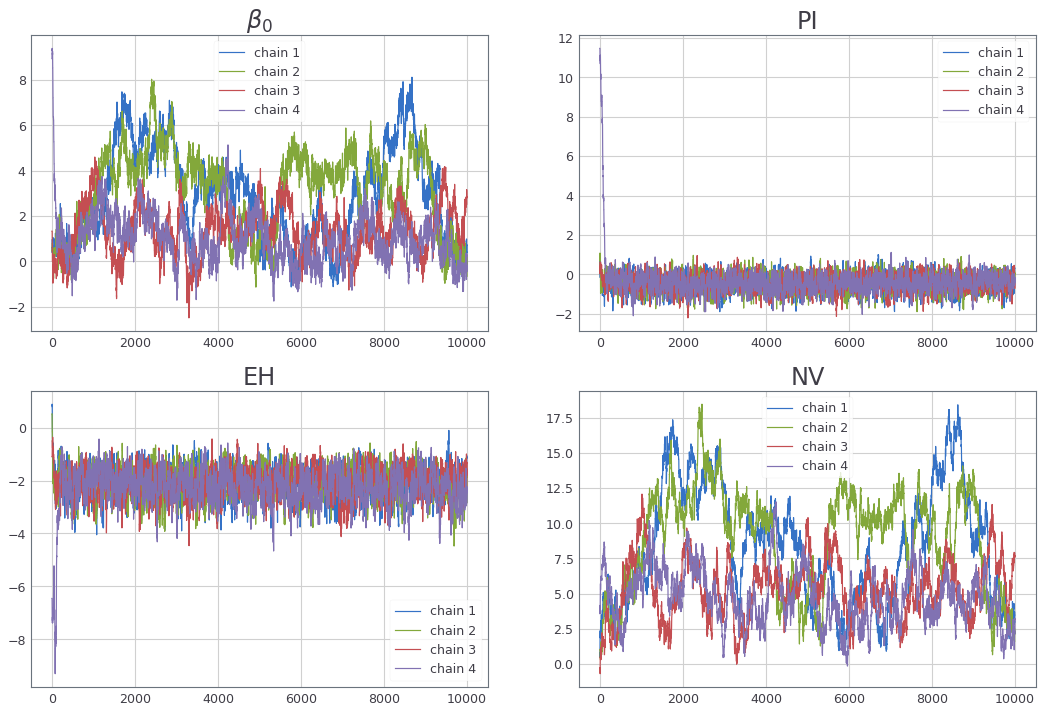

In [38]:
# plot the traces of samples per chain to observe convergence 
p = plot_traces(samples)
p.savefig("../../seminar_paper/figures/endometrial_traces.png", transparent=True)
plt.show(p);

### Inspect Potential Scale Reduction Factor, $\hat{R}$

 - _estimate_ of convergence based on the with-in-chain and between-chain variance of $\theta_i$
 - $\sim$ _"factor by which the variance will reduce when running the chain longer"_ 
 - longer chains are beneficial in all cases
 - esp. for $\beta_0$ and $NV$

In [9]:
print(f"Gelman Rubin metric: {gelman_rubin(samples)}")

Gelman Rubin metric: [1.05830603 1.00219912 1.00100171 1.06172795]


### Posterior Distributions of chains 1-3

 - convergence of $PI$ and $EH$ observed in posteriors 
 - chain 1 & 3 tend to be similar; $q_0 = 1$ and $q_0 \sim \mathcal{N}(0,1)$

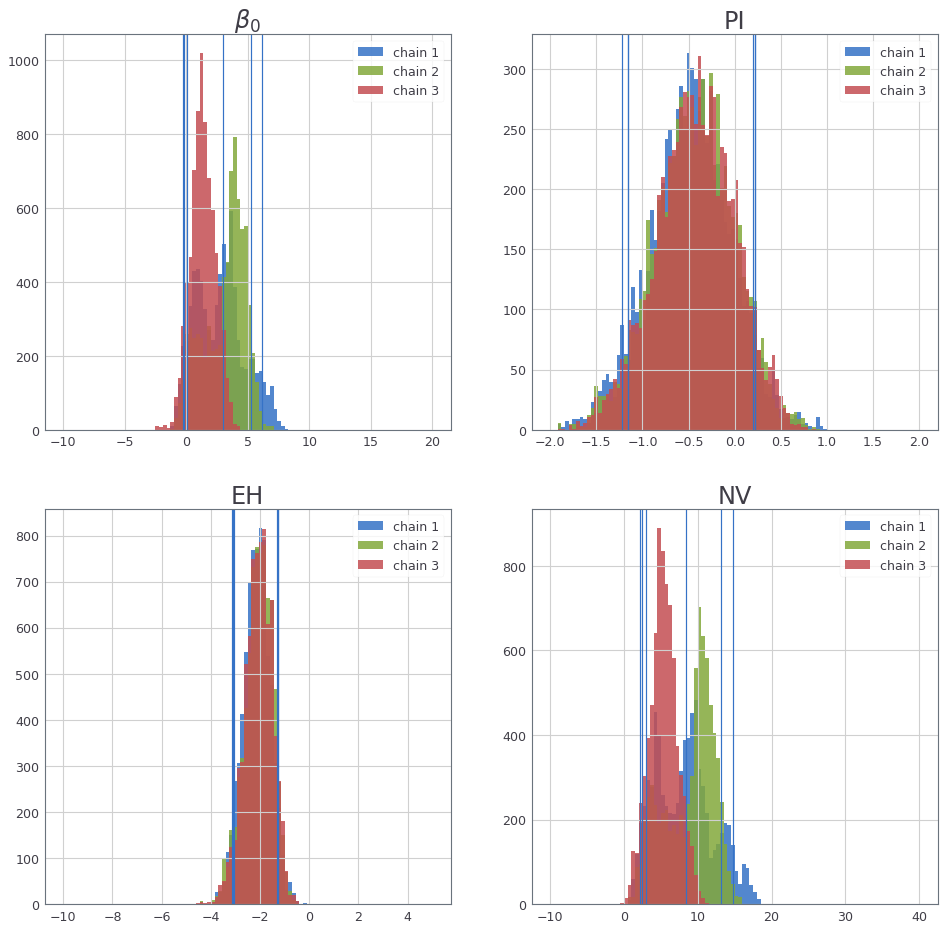

In [37]:
# plot the distribution of samples per chain and credible intervals 
# .5 and .94 quantiles for the 89% credible intervals [3] in blue 
p = plot_histograms(samples[:3, burnin:, :])
p.savefig("../../seminar_paper/figures/endometrial_distributions.png", transparent=True)
plt.show(p);

## Conclusion 

 - HMC reaches similar statistics after $1E5$ steps $\to$ two orders of mag. 
 - to yield the anticipated acceptance prob. of $65\%$ decrease step size - but it was OK for two of four variables 
 - able to use relatively large step size

 ```
           25%          50%             75%   
b0  1.268 ( 1.024)  2.721 ( 2.058)  4.683 ( 2.999)
PI -0.766 (-0.719) -0.455 (-0.420) -0.158 (-0.137)
EH -2.515 (-2.440) -2.100 (-2.070) -1.722 (-1.688)
NV  5.229 ( 4.862)  8.126 ( 6.803) 12.041 ( 8.722)
 ```

In [20]:
# compute quantiles of estimates per chain 
quantiles = quantiles_per_chain(samples, burnin)

# inspect estimates of third chain
print(f"b0: \t {quantiles[0, 2, :]}")
print(f"PI: \t {quantiles[1, 2, :]}")
print(f"EH: \t {quantiles[2, 2, :]}")
print(f"NV: \t {quantiles[3, 2, :]}")

b0: 	 [-0.62347626  0.70723798  1.32149763  2.05170206  3.29370182]
PI: 	 [-1.30447867 -0.70569923 -0.417508   -0.12544029  0.39438866]
EH: 	 [-3.30716489 -2.43290495 -2.03948978 -1.67139195 -1.07171959]
NV: 	 [1.49569288 4.15987019 5.32648382 6.54041791 9.24305581]


### Predicting with obtained Coefficients 

 - use $\beta_{0}, \dots, \beta_{3}$ to predict one data set
 - w.r.t. BCE, results are comparable with far less computational expense

In [133]:
# the 50%-percentile of the reference model 
beta_mh = np.array([2.721, -.455, -2.1, 8.126])

# the 50%-percentiles of the current samples 
beta_hat = quantiles[:, 2, 2]

# compute predictions using Simgoid link 
y_hat = 1 / (1 + np.exp(-X @ beta_hat))
y_hat_mh = 1 / (1 + np.exp(-X @ beta_mh))

# compute BCE loss
binary_ce_hmc = 1/X.shape[0] * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
binary_ce_mh = 1/X.shape[0] * np.sum(y * np.log(y_hat_mh) + (1 - y) * np.log(1 - y_hat_mh))

print(f"Binary Cross Entropy Loss comparison")
print(f"HMC model: {binary_ce_hmc:.5f} vs. MH model: {binary_ce_mh:.5f}")

Binary Cross Entropy Loss comparison
HMC model: -0.35138 vs. MH model: -0.35140


## Model Definition - Regression
 - regression with $y \sim \mathcal{N}(X\beta, \sigma^2_y I)$
 - $\beta \sim \mathcal{N}(0, \sigma^2_{\beta} I), \quad \sigma_{\beta} = 10$
 - $\sigma_y \sim \mathcal{IG}(\alpha=1, \beta=1)$
 - parameter vector $\theta = (\beta_0, \dots, \beta_n, \sigma_y)'$
 - derive prop. log posterior and its gradient
     $$
     \begin{align}
         \log p(\beta, \sigma^2 \vert \cdot) &\propto \log p(y \vert \cdot) + \log p(\beta \vert \cdot) + \log p(\sigma^2 \vert \cdot)  \\
         \nabla_{\beta, \sigma^2} \log p(\beta, \sigma^2 \vert \cdot) &\propto \left(\nabla_{\beta} \log p(\beta, \sigma^2 \vert \cdot), \nabla_{\sigma^2} \log p(\beta, \sigma^2 \vert \cdot)\right) 
     \end{align}
     $$

### References 

- [1] _"A solution to the problem of separation in logistic regression"_ , Georg Heinze and Michael Schemper, 2002
- [2] _"Foundations of linear and generalized linear models"_ , Alan Agresti, 2015
- [3] _"bayestestR: Describing Effects and their Uncertainty, Existence and Significance within the Bayesian Framework"_ , Makowski, D. and Ben-Shachar, M. S. and Lüdecke, D., 2019  

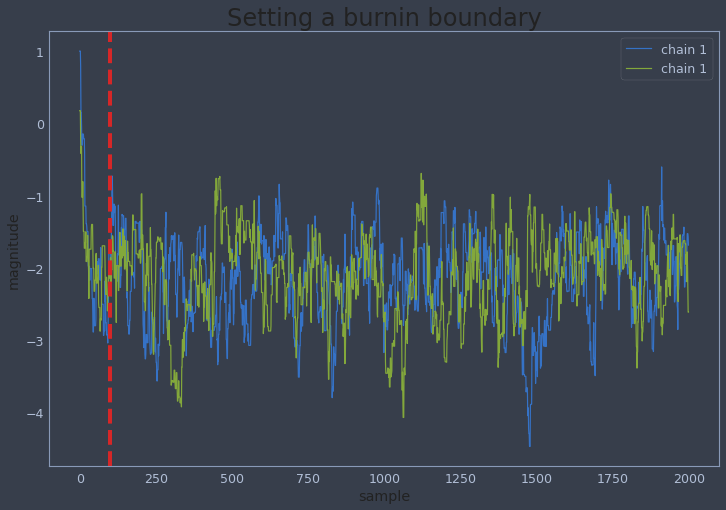

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(samples[0, :2000, 2], label="chain 1")
ax.plot(samples[1, :2000, 2], label="chain 1")
ax.axvline(100, linewidth=4, color="#d62728", ls="--")
ax.legend()
ax.set_title("Setting a burnin boundary", fontsize=24, color="k")
ax.set_xlabel("sample", color="k")
ax.set_ylabel("magnitude", color="k")
ax.grid(False)
plt.savefig("./../../presentation/figures/burning_illustration.png", 
            transparent=True, dpi=300)
plt.show();

In [22]:
quantiles[:, 0, 2]

array([ 2.81266224, -0.47419567, -2.13231312,  8.30476783])

In [23]:
quantiles[:, 1, 2]

array([ 3.59941959, -0.43042729, -2.02844551,  9.94553054])

In [24]:
quantiles[:, 2, 2]

array([ 1.32149763, -0.417508  , -2.03948978,  5.32648382])

In [25]:
quantiles[:, 3, 2]

array([ 0.73626475, -0.45933214, -2.2398439 ,  4.17063627])